# Training biophysical models

In this tutorial, you will learn how to train biophysical models in `Jaxley`. This includes the following:

- compute the gradient with respect to parameters  
- use parameter transformations  
- use multi-level checkpointing  
- define optimizers  
- write dataloaders and parallelize across data  

Here is a code snippet which you will learn to understand in this tutorial:
```python
from jax import jit, vmap, value_and_grad
import jaxley as jx
import jaxley.optimize.transforms as jt

net = ...  # See tutorial on the basics of `Jaxley`.

# Define which parameters to train.
net.cell("all").make_trainable("HH_gNa")
net.IonotropicSynapse.make_trainable("IonotropicSynapse_gS")
parameters = net.get_parameters()

# Define parameter transform and apply it to the parameters.
transform = jx.ParamTransform([{"IonotropicSynapse_gS": jt.SigmoidTransform(0.0,1.0)},
                               {"HH_gNa":jt.SigmoidTransform(0.0,1,0)}])

opt_params = transform.inverse(parameters)

# Define simulation and batch it across stimuli.
def simulate(params, datapoint):
    current = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amps=datapoint, dt=0.025, t_max=5.0)
    data_stimuli = net.cell(0).branch(0).comp(0).data_stimulate(current, None
    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_inds=[20, 20])

batch_simulate = vmap(simulate, in_axes=(None, 0))

# Define loss function and its gradient.
def loss_fn(opt_params, datapoints, label):
    params = transform.forward(opt_params)
    voltages = batch_simulate(params, datapoints)
    return jnp.abs(jnp.mean(voltages) - label)

grad_fn = jit(value_and_grad(loss_fn, argnums=0))

# Define data and dataloader.
data = jnp.asarray(np.random.randn(100, 3))
dataloader = Dataset.from_tensor_slices((inputs, labels))
dataloader = dataloader.shuffle(dataloader.cardinality()).batch(4)

# Define the optimizer.
optimizer = optax.Adam(lr=0.01)
opt_state = optimizer.init_state(opt_params)

for epoch in range(10):
    for batch in dataloader:
        stimuli = batch[0].numpy()
        labels = batch[1].numpy()
        loss, gradient = grad_fn(opt_params, stimuli, labels)

        # Optimizer step.
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        
```

In [1]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import Leak
from jaxley.synapses import TanhRateSynapse
from jaxley.connect import fully_connect

First, we define a network as you saw in the [previous tutorial](https://jaxleyverse.github.io/jaxley/latest/tutorial/01_morph_neurons/):

In [2]:
_ = np.random.seed(0)  # For synaptic locations.

comp = jx.Compartment()
branch = jx.Branch(comp, nseg=2)
cell = jx.Cell(branch, parents=[-1, 0, 0])
net = jx.Network([cell for _ in range(3)])

pre = net.cell([0, 1])
post = net.cell([2])
fully_connect(pre, post, TanhRateSynapse())

# Change some default values of the tanh synapse.
net.TanhRateSynapse.set("TanhRateSynapse_x_offset", -60.0)
net.TanhRateSynapse.set("TanhRateSynapse_gS", 1e-3)
net.TanhRateSynapse.set("TanhRateSynapse_slope", 0.1)

net.insert(Leak())

This network consists of three neurons arranged in two layers:

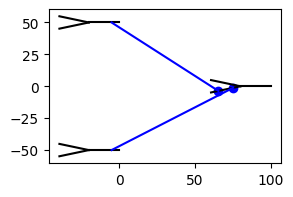

In [3]:
net.compute_xyz()
net.rotate(180)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = net.vis(ax=ax, detail="full", layers=[2, 1], layer_kwargs={"within_layer_offset": 100.0, "between_layer_offset": 100.0}) 

We consider the last neuron as the output neuron and record the voltage from there:

In [4]:
net.delete_recordings()
net.cell(0).branch(0).loc(0.0).record()
net.cell(1).branch(0).loc(0.0).record()
net.cell(2).branch(0).loc(0.0).record()

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.


### Defining a dataset

We will train this biophysical network on a classification task. The inputs will be values and the label is binary:

In [5]:
inputs = jnp.asarray(np.random.rand(100, 2))
labels = jnp.asarray((inputs[:, 0] + inputs[:, 1]) > 1.0)

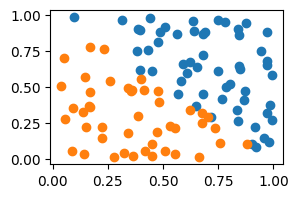

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(inputs[labels, 0], inputs[labels, 1])
_ = ax.scatter(inputs[~labels, 0], inputs[~labels, 1])

In [7]:
labels = labels.astype(float)

### Defining trainable parameters

In [8]:
net.delete_trainables()

This follows the same API as `.set()` seen in the previous tutorial. If you want to use a single parameter for all `radius`es in the entire network, do:

In [9]:
net.make_trainable("radius")

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1


We can also define parameters for individual compartments. To do this, use the `"all"` key. The following defines a separate parameter the sodium conductance for every compartment in the entire network:

In [10]:
net.cell("all").branch("all").loc("all").make_trainable("Leak_gLeak")

Number of newly added trainable parameters: 18. Total number of trainable parameters: 19


### Making synaptic parameters trainable

Synaptic parameters can be made trainable in the exact same way. To use a single parameter for all syanptic conductances in the entire network, do
```python
net.TanhRateSynapse.make_trainable("TanhRateSynapse_gS")
```

Here, we use a different syanptic conductance for all syanpses. This can be done as follows:

In [11]:
net.TanhRateSynapse.edge("all").make_trainable("TanhRateSynapse_gS")

Number of newly added trainable parameters: 2. Total number of trainable parameters: 21


### Running the simulation

Once all parameters are defined, you have to use `.get_parameters()` to obtain all trainable parameters. This is also the time to check how many trainable parameters your network has:

In [12]:
params = net.get_parameters()

You can now run the simulation with the trainable parameters by passing them to the `jx.integrate` function.

In [13]:
s = jx.integrate(net, params=params, t_max=10.0)

### Stimulating the network

The network above does not yet get any stimuli. We will use the 2D inputs from the dataset to stimulate the two input neurons. The amplitude of the step current corresponds to the input value. Below is the simulator that defines this:

In [14]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10, delta_t=0.025, t_max=10.0)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli)

batched_simulate = vmap(simulate, in_axes=(None, 0))

We can also inspect some traces:

In [15]:
traces = batched_simulate(params, inputs[:4])

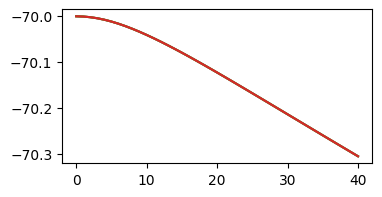

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(traces[:, 2, :].T)

### Defining a loss function

Let us define a loss function to be optimized:

In [17]:
def loss(params, inputs, labels):
    traces = batched_simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[:, 2], axis=1)  # Use the average over time of the output neuron (2) as prediction.
    prediction = (prediction + 72.0) / 5  # Such that the prediction is roughly in [0, 1].
    losses = jnp.abs(prediction - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

And we can use `JAX`'s inbuilt functions to take the gradient through the entire ODE:

In [18]:
#jitted_grad = jit(value_and_grad(loss, argnums=0))
jitted_grad = (value_and_grad(loss, argnums=0))

In [19]:
value, gradient = jitted_grad(params, inputs[:4], labels[:4])

### Defining parameter transformations

Before training, however, we will enforce for all parameters to be within a prespecified range (such that, e.g., conductances can not become negative)

In [20]:
import jaxley.optimize.transforms as jt

In [21]:
# Define a function to create appropriate transforms for each parameter
def create_transform(name):
    if name == "axial_resistivity":
        # Must be positive; apply Softplus and scale to match initialization
        return jt.ChainTransform([jt.SoftplusTransform(0), jt.AffineTransform(5000, 0)])
    elif name == "length":
        # Apply Softplus and affine transform for the 'length' parameter
        return jt.ChainTransform([jt.SoftplusTransform(0), jt.AffineTransform(10, 0)])
    else:
        # Default to a Softplus transform for other parameters
        return jt.SoftplusTransform(0)

# Apply the transforms to the parameters
transforms = [{k: create_transform(k) for k in param} for param in params]
tf = jt.ParamTransform(transforms)


In [22]:
transform = jx.ParamTransform([{"radius": jt.SigmoidTransform(0.1,5.0)},
                               {"Leak_gLeak":jt.SigmoidTransform(1e-5,1e-3)},
                               {"TanhRateSynapse_gS" : jt.SigmoidTransform(1e-5,1e-2)}])

With these  modify the loss function acocrdingly:

In [23]:
def loss(opt_params, inputs, labels):
    transform.forward(opt_params)

    traces = batched_simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[:, 2], axis=1)  # Use the average over time of the output neuron (2) as prediction.
    prediction = (prediction + 72.0)  # Such that the prediction is around 0.
    losses = jnp.abs(prediction - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

### Using checkpointing

Checkpointing allows to vastly reduce the memory requirements of training biophysical models.

In [24]:
t_max = 5.0
dt = 0.025

levels = 2
time_points = t_max // dt + 2
checkpoints = [int(np.ceil(time_points**(1/levels))) for _ in range(levels)]

To enable checkpointing, we have to modify the `simulate` function appropriately and use
```python
jx.integrate(..., checkpoint_inds=checkpoints)
```
as done below:

In [25]:
def simulate(params, inputs):
    currents = jx.datapoint_to_step_currents(i_delay=1.0, i_dur=1.0, i_amp=inputs / 10.0, delta_t=dt, t_max=t_max)

    data_stimuli = None
    data_stimuli = net.cell(0).branch(2).loc(1.0).data_stimulate(currents[0], data_stimuli=data_stimuli)
    data_stimuli = net.cell(1).branch(2).loc(1.0).data_stimulate(currents[1], data_stimuli=data_stimuli)

    return jx.integrate(net, params=params, data_stimuli=data_stimuli, checkpoint_lengths=checkpoints)

batched_simulate = vmap(simulate, in_axes=(None, 0))


def predict(params, inputs):
    traces = simulate(params, inputs)  # Shape `(batchsize, num_recordings, timepoints)`.
    prediction = jnp.mean(traces[2])  # Use the average over time of the output neuron (2) as prediction.
    return prediction + 72.0  # Such that the prediction is around 0.

batched_predict = vmap(predict, in_axes=(None, 0))


def loss(opt_params, inputs, labels):
    params = transform.forward(opt_params)

    predictions = batched_predict(params, inputs)
    losses = jnp.abs(predictions - labels)  # Mean absolute error loss.
    return jnp.mean(losses)  # Average across the batch.

#jitted_grad = jit(value_and_grad(loss, argnums=0))
jitted_grad = (value_and_grad(loss, argnums=0))

### Training

We will use the ADAM optimizer from the [optax library](https://optax.readthedocs.io/en/latest/) to optimize the free parameters (you have to install the package with `pip install optax` first):

In [26]:
import optax

In [27]:
opt_params = transform.inverse(params)
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(opt_params)

### Writing a dataloader

In [28]:
import tensorflow as tf
from tensorflow.data import Dataset

In [29]:
batch_size = 4

tf.random.set_seed(1)
dataloader = Dataset.from_tensor_slices((inputs, labels))
dataloader = dataloader.shuffle(dataloader.cardinality()).batch(batch_size)

### Training loop

In [ ]:
for epoch in range(10):
    epoch_loss = 0.0
    for batch_ind, batch in enumerate(dataloader):
        current_batch = batch[0].numpy()
        label_batch = batch[1].numpy()
        loss_val, gradient = jitted_grad(opt_params, current_batch, label_batch)
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)
        epoch_loss += loss_val
    
    print(f"epoch {epoch}, loss {epoch_loss}")
    
final_params = transform.forward(opt_params)

In [261]:
ntest = 32
predictions = batched_predict(final_params, inputs[:ntest])

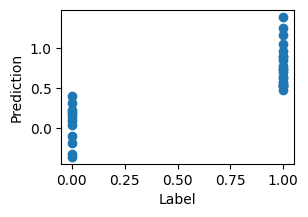

In [263]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
_ = ax.scatter(labels[:ntest], predictions)
_ = ax.set_xlabel("Label")
_ = ax.set_ylabel("Prediction")

Indeed, the loss goes down and the network successfully classifies the patterns.

### Summary

Puh, this was a pretty dense tutorial with a lot of material. You should have learned how to:

- compute the gradient with respect to parameters  
- use parameter transformations  
- use multi-level checkpointing  
- define optimizers  
- write dataloaders and parallelize across data  

This was one of the last tutorials of the `Jaxley` toolbox. If anything is still unclear please create a [discussion](https://github.com/jaxleyverse/jaxley/discussions). If you find any bugs, please open an [issue](https://github.com/jaxleyverse/jaxley/issues). Happy coding!